In [32]:
import os
import glob
import numpy as np
import itertools
import random
import multiprocessing

from skimage import feature
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from scipy import ndimage

from sklearn.model_selection import train_test_split
from sklearn import linear_model
%matplotlib inline

In [2]:
path = 'data/flowers/'

In [3]:
img_width = img_height=128

In [4]:
def preProcessing(img):
    
    img = resizeImage(img)
    img = RGB2Gray(img)
    img = median_filter(img)
    img = addDelta(img)
    img = vectorizeImage(img)
    return img

In [5]:
def addDelta(img):
    return img + 1e-3

In [6]:
def vectorizeImage(img, img_width=128, img_height=128):
    return img.reshape(-1,img_width * img_height)

In [7]:
def median_filter(img, factor=2):
    
    filtered = ndimage.median_filter(img, factor)
    img = img - filtered
    return img   

In [8]:
def resizeImage(img, img_width=128, img_height=128):
    img = img.resize((img_width, img_height))
    return np.array(img)

In [9]:
def localBinaryPatterns(img, numPoints=24, radius=2):
    
    lbp = feature.local_binary_pattern(img, numPoints,
                    radius, method="uniform")
    return lbp

In [10]:
def RGB2Gray(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114]).astype(int)

In [11]:
def get_data(path):
    X, y =  [], []
    count = 0
    labels = {}
    for subdir, dirs, files in os.walk(path):
        if subdir.split('/')[-1] != '':
            labels[count] = subdir.split('/')[-1]
            path_folder = os.path.join(subdir, '*.jpg')
            filesPath = glob.glob(path_folder) 
            
            for fileName in filesPath:
                with Image.open(fileName) as img:
                    img = preProcessing(img)
                    X.append(img)

            y.extend(np.full((1, len(filesPath)), count, dtype=int)[0])
            count+=1
    return (X, y, labels)

In [12]:
X, y, labels = get_data(path)

In [13]:
def showCamaraPhotos(X, y, labels, img_width=128, img_height=128):

    idx = random.randint(0,len(X))
    plt.title(labels[y[idx]])
    img = X[idx].reshape(img_width, img_height)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

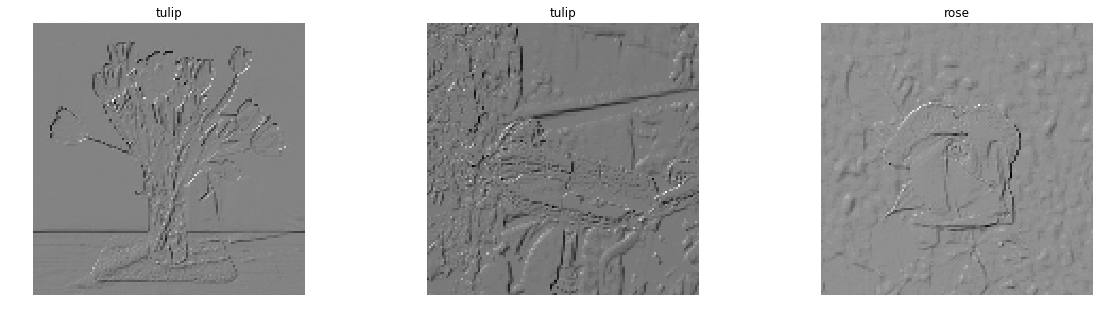

In [14]:
plt.figure(figsize=(20,5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    showCamaraPhotos(X, y, labels)

In [15]:
X = np.squeeze(np.array(X), axis=1)
y = np.array(y)

In [16]:
print('Shape of the data X: {}, y: {}'.format(X.shape, y.shape))

Shape of the data X: (4323, 16384), y: (4323,)


In [17]:
test_size = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)

In [18]:
print('Shape of the training data X: {}, y: {}'.format(X_train.shape, y_train.shape))
print('Shape of the valid data X: {}, y: {}'.format(X_valid.shape, y_valid.shape))

Shape of the training data X: (3458, 16384), y: (3458,)
Shape of the valid data X: (865, 16384), y: (865,)


### Normalization

In [19]:
def MinMaxNormalization(X, y, x_factor={}, y_factor = {}, transformation = False):

    if not(transformation):
        x_factor = {'min': X.min(axis=0), 'max': X.max(axis=0)}
        y_factor = {'min': y.min(axis=0), 'max': y.max(axis=0)}

    X = (X - x_factor['min'])/(x_factor['max']-x_factor['min'])
    if len(y)  != 0:
        y = (y - y_factor['min']) / (y_factor['max'] - y_factor['min'])
    
    return X, y, x_factor, y_factor

In [20]:
def zScoreNormalization(X, y, x_factor={}, y_factor = {}, transformation = False):
    
    if not(transformation):
        x_factor = {'mean': X.mean(axis=0), 'std': X.std(axis=0)}
        y_factor = {'mean': y.mean(axis=0), 'std': y.std(axis=0)}

    X=(X-x_factor['mean'])/x_factor['std']
    
    if len(y)  != 0:
        y=(y-y_factor['mean'])/y_factor['std']
    
    return X, y, x_factor, y_factor

In [21]:
normalization_type = 'zScore'

In [22]:
print('Normalization type: {}'.format(normalization_type))

if normalization_type == 'minMax':
    
    X_train, _, x_factor, y_factor  = MinMaxNormalization(X_train, y_train)
    X_valid, _, _, _  = MinMaxNormalization(X_valid, y_valid, x_factor=x_factor, y_factor=y_factor, transformation=True)
    #X_test, _, _, _  = MinMaxNormalization(X_test, [], x_factor=x_factor, y_factor=y_factor, transformation=True)

elif normalization_type == 'zScore':
        
    X_train, _, x_factor, y_factor  = zScoreNormalization(X_train, y_train)
    X_valid, _, _, _  = zScoreNormalization(X_valid, y_valid, x_factor=x_factor, y_factor=y_factor, transformation=True)
    #X_test, _, _, _  = zScoreNormalization(X_test, [], x_factor=x_factor, y_factor=y_factor, transformation=True)

Normalization type: zScore


### Model

In [34]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 7


In [37]:
model = linear_model.LogisticRegression(multi_class='multinomial', n_jobs=cpu_count, verbose=1, solver = 'newton-cg')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_valid)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_valid, y_valid)))